先import一些library

In [1]:
import datetime
import os
import time
import warnings
import gc
# import presets
import torch
import torch.utils.data
import torchvision
from tmp_modules import utils,transforms

# from coco_utils import get_coco
from torch import nn
from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import functional as F, InterpolationMode
import torchvision.transforms as transforms
try:
    from pytorch_model_summary import summary
except:
    !pip install pytorch-model-summary
    from pytorch_model_summary import summary

try:
    from torchviz import make_dot
except:
    !pip install torchviz
    from torchviz import make_dot

import transformers
try:
    import datasets
except:
    !pip install cchardet
    !pip install datasets
    import datasets
    
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from IPython.display import clear_output, display

try:
        from thop import profile
except:
        !pip install thop

import torch
from transformers import SamModel, SamProcessor

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


先定義一些function

In [2]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

def KD_criterion(student_outputs, teacher_outputs, labels, temperature=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    """
    print("student_outputs size = ", student_outputs["out"].size())
    print("student_outputs = ", student_outputs["out"])
    print("teacher_outputs size = ", teacher_outputs[0].size())
    print("teacher_outputs = ", teacher_outputs[0])
    """
    # Calculate Cross Entropy
    original_loss = nn.functional.cross_entropy(student_outputs["out"], labels, ignore_index=255)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0][0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs["out"][0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # 總損失為原始損失加上蒸餾損失
    total_loss = original_loss + distillation_loss

    return total_loss


def evaluate(model, data_loader, device, num_classes):
    model.eval()
    model.to(device)

    header = "Test:"
    num_processed_samples = 0
    total_loss            = 0
    with torch.inference_mode():
        for image, target in data_loader:
            image, target = image.to(device), target.to(device)

            ###
            target = target.squeeze(1)
            # Convert target to Long type
            target = target.type(torch.LongTensor).to(device)
            
            output = model(image)
            loss = criterion(output, target)
            total_loss += loss.item()
            # output = output["out"]
            # confmat.update(target.flatten(), output.argmax(1).flatten())
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            num_processed_samples += image.shape[0]
            
            del image, target, output, loss

            gc.collect()
            torch.cuda.empty_cache()
    return total_loss/ num_processed_samples

# 用utils.py裡的MetricLogger去iterate through all the data.
def train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, epoch, scaler=None):
    model.train()
    training_loss = []

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value}"))
    header = f"Epoch: [{epoch}]"
    for image, target in metric_logger.log_every(data_loader, 10, header):
        image, target = image.to(device), target.to(device)

        ###
        target = target.squeeze(1)
        # Convert target to Long type
        target = target.type(torch.LongTensor).to(device)

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            output = model(image)
            loss = criterion(output, target)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        training_loss.append(loss.item())
    return np.mean(np.array(training_loss))

# 用enumerate去iterate through all the data.
def train_one_epoch_01(student_model, teacher_model, processor, criterion, optimizer, data_loader, lr_scheduler, device, pbar, scaler=None):
    student_model.train()
    teacher_model.eval()
    training_loss = []
    for idx, (image, target) in enumerate(data_loader):
        image, target = image.to(device), target.to(device)

        ### ground truth given by annotation
        target = target.squeeze(1)
        # Convert target to Long type
        target = target.type(torch.LongTensor).to(device)
        ############################################################### Teacher Model : SAM
        # Retrieve the image embeddings
        # processor
        inputs = processor(image, return_tensors="pt").to(device)
        image_embeddings = teacher_model.get_image_embeddings(inputs["pixel_values"])

        # 待加功能$$$$$
        # setup prompts : target points, bounding box
        input_boxes = [[[250, 300, 700, 550]]]
        input_points = [[[500, 400], [600, 400]]]
        
        # 送到processor計算遮罩
        inputs = processor(image, input_boxes=[input_boxes], input_points=[input_points], return_tensors="pt").to(device)
        # inputs = processor(raw_image, input_points=[input_points], return_tensors="pt").to(device)

        inputs.pop("pixel_values", None)
        inputs.update({"image_embeddings": image_embeddings})
        """
        with torch.no_grad():
            outputs = model(**inputs)

        masks, teacher_output = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
        """
        ###############################################################
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            student_output = student_model(image)
            sam_outputs = teacher_model(**inputs)
            masks, teacher_output = processor.image_processor.post_process_masks(sam_outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
            #print("output-->", output)
            loss = criterion(student_output, teacher_output, target)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.update(idx, values=[("loss",loss.item())])

        training_loss.append(loss.item())

        del image, target, student_output, loss

        gc.collect()
        torch.cuda.empty_cache()
    '''
        except:
            print('except: *************')
            error_count += 1
            if error_count < 10:
                model.to('cpu')
                gc.collect()
                torch.cuda.empty_cache()
                model.to(device)
                model.train()
            else:
                raise RuntimeError('GPU out of memory error')
    '''
    return np.mean(np.array(training_loss))

def train(student_model, teacher_model, processor, epochs, data_loader, data_loader_valid, early_stop=0, model_pathname=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(torch.cuda.get_device_name(0))
    print(device)
    gc.collect()
    torch.cuda.empty_cache()

    student_model.to(device)
    teacher_model.to(device)
    if hasattr(student_model,'backbone'):
        params_to_optimize = [
            {"params": [p for p in student_model.backbone.parameters() if p.requires_grad]},
            {"params": [p for p in student_model.classifier.parameters() if p.requires_grad]},
        ]
    else:
        params_to_optimize = [{ "params": student_model.parameters() }]

    optimizer = torch.optim.Adam(params_to_optimize)
    scaler = None #torch.cuda.amp.GradScaler()
    iters_per_epoch = len(data_loader)
    lr_scheduler    = None # PolynomialLR(optimizer, total_iters=iters_per_epoch * epochs, power=0.9)
    training_loss   = []
    val_loss        = []
    min_val_loss    = np.inf
    min_val_epoch   = 0
    start_time = time.time()

    n_batch = len(data_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch,stateful_metrics=['val_loss'])

    for epoch in range(epochs):
        
        print(f'Epoch {epoch+1}/{epochs}')

        #tr_loss = train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, 10, scaler)
        tr_loss = train_one_epoch_01(student_model, teacher_model, processor, KD_criterion, optimizer, data_loader, lr_scheduler, device, pbar, scaler)
        
        #print(tr_loss)
        training_loss.append(tr_loss)

        if data_loader_valid is not None:
            v_loss = evaluate(student_model, data_loader_valid, device=device, num_classes=2)
            val_loss.append(v_loss)
            pbar.update(n_batch, values=[('val_loss', v_loss)])

            # save the parameters with the least loss
            if v_loss < min_val_loss:
                min_val_loss = v_loss
                min_val_epoch= epoch
                if model_pathname is not None:
                    torch.save(student_model.state_dict(),model_pathname)

            # early stop
            if early_stop > 0 and epoch - min_val_epoch >= early_stop:
                break

        if lr_scheduler is not None:
            checkpoint = {
                "model": student_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "epoch": epoch,
            } 
        else:
            checkpoint = {
                "model": student_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
            } 

    if data_loader_valid is not None and model_pathname is not None:
        student_model.load_state_dict(torch.load(model_pathname))

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time {total_time_str}")
    return {'loss':training_loss,'val_loss':val_loss}

def showSegmentationResult(model, dataset, num_images=3):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for i, idx in enumerate(range(min(len(dataset), num_images))):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))   
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(target.permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')

        # Model Prediction
        plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        overlay = image.clone()
        overlay[0, labels == 1] = 1
        plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(np.transpose(overlay.squeeze().cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

    plt.show()

    print("outputs['out'] size = ", outputs['out'].size())
    print(outputs['out'])
    print("labels = ", labels)
    return

準備資料集

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SplashDataSet(Dataset):
    def __init__(self, data_dir, train, transform=None):
        # check for training or validation
        if train:
            split = 'training'
        else:
            split = 'validation'
        # get the directory path
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, 'images', split)
        self.annotations_dir = os.path.join(data_dir, 'annotations', split)
        # check the number of image and mask in two directory: images and annotations
        self.images_list = os.listdir(self.images_dir)
        self.annotations_list = os.listdir(self.annotations_dir)
        assert len(self.images_list) == len(self.annotations_list), "Number of images and annotations should be the same."
        
        self.transform = transform
    def __len__(self):
        return len(self.images_list)
    def __getitem__(self, idx):
        # 讀取原圖
        img_name = os.path.join(self.images_dir, self.images_list[idx])
        image = Image.open(img_name)

        # 讀取遮罩
        mask_name = os.path.join(self.annotations_dir, self.annotations_list[idx])
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # 因為只有一個類別，將 mask 轉換成二元的 0 和 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        return image, mask

定義Segformer，直接用包好的

In [4]:
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation

class SegFormer(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()})
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}        

定義SAM

In [5]:
############################################################### Teacher Model : SAM
# define SAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

print(summary(sam_model, torch.zeros((1, 3, 1024, 1024)).to(device), show_input=True, show_parent_layers=True, max_depth=1))


---------------------------------------------------------------------------------------------
   Parent Layers          Layer (type)            Input Shape         Param #     Tr. Param #
        SamModel    SamVisionEncoder-1     [1, 3, 1024, 1024]     637,026,048     637,026,048
        SamModel    SamPromptEncoder-2                                  6,220           6,220
        SamModel      SamMaskDecoder-3                              4,058,340       4,058,340
Total params: 641,090,608
Trainable params: 641,090,608
Non-trainable params: 0
---------------------------------------------------------------------------------------------


In [6]:
from transformers import SegformerForSemanticSegmentation
from datasets import load_metric
from torch.utils.data import DataLoader
import tkinter as tk
from tkinter import filedialog
from thop import profile

# transform the image
transform = transforms.Compose([
    # transforms.Resize((1080, 1920)),
    # transforms.Resize((540, 960)),
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

num_classes           = 2
segformer_transform   = transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128,128),antialias=True)])
segformer_target_transform = transforms.Compose([lambda x:torch.from_numpy(cv2.resize(np.asarray(x),(128,128),cv2.INTER_NEAREST).astype(np.int64)-1)])

data_folder = select_folder()

# create SplashDataSet
dataset = SplashDataSet(data_dir=data_folder, train=True, transform=transform)
dataset_val = SplashDataSet(data_dir=data_folder, train=False, transform=transform)

# use DataLoader to load data in batch_size
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True)
"""
segformer_train_sampler = torch.utils.data.RandomSampler(dataset)
segformer_test_sampler  = torch.utils.data.SequentialSampler(dataset_val)

segformer_data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        sampler=segformer_train_sampler,
        num_workers=0,
        collate_fn=utils.collate_fn,
        drop_last=True)

segformer_data_loader_valid = torch.utils.data.DataLoader(
       dataset_val, batch_size=1, sampler=segformer_test_sampler, num_workers=0, collate_fn=utils.collate_fn)
"""
segformer_model = SegFormer(num_classes)

print(summary(segformer_model, torch.zeros((1, 3, 1024, 1024)), show_input=True, show_parent_layers=True, max_depth=1))

# 計算FLOP
flops, params = profile(segformer_model, inputs=(torch.zeros((1, 3, 1024, 1024)),), verbose=False)
print("FLOPs =", '{:,.0f}'.format(flops))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-------------------------------------------------------------------------------------------------------------
   Parent Layers                          Layer (type)            Input Shape         Param #     Tr. Param #
       SegFormer    SegformerForSemanticSegmentation-1     [1, 3, 1024, 1024]      13,677,762      13,677,762
Total params: 13,677,762
Trainable params: 13,677,762
Non-trainable params: 0
-------------------------------------------------------------------------------------------------------------
FLOPs = 52,974,059,520


In [7]:
# lc = train(segformer_model,5,segformer_data_loader,segformer_data_loader_valid,model_pathname='segformer.pth')
lc = train(segformer_model, sam_model, processor,10,dataloader, dataloader_val)

NVIDIA GeForce RTX 4090
cuda


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


1/1 [==============================] - 7s 7s/step - loss: 0.7597 - val_loss: 0.7189
Epoch 2/10
1/1 [==============================] - 14s 14s/step - loss: 0.7191 - val_loss: 0.6993
Epoch 3/10
1/1 [==============================] - 20s 20s/step - loss: 0.6911 - val_loss: 0.7013
Epoch 4/10
1/1 [==============================] - 27s 27s/step - loss: 0.6469 - val_loss: 0.6569
Epoch 5/10
1/1 [==============================] - 33s 33s/step - loss: 0.6082 - val_loss: 0.6291
Epoch 6/10
1/1 [==============================] - 40s 40s/step - loss: 0.5698 - val_loss: 0.5832
Epoch 7/10
1/1 [==============================] - 46s 46s/step - loss: 0.5303 - val_loss: 0.5389
Epoch 8/10
1/1 [==============================] - 53s 53s/step - loss: 0.4955 - val_loss: 0.5002
Epoch 9/10
1/1 [==============================] - 59s 59s/step - loss: 0.4638 - val_loss: 0.4958
Epoch 10/10
1/1 [==============================] - 66s 66s/step - loss: 0.4356 - val_loss: 0.4679
Training time 0:01:05


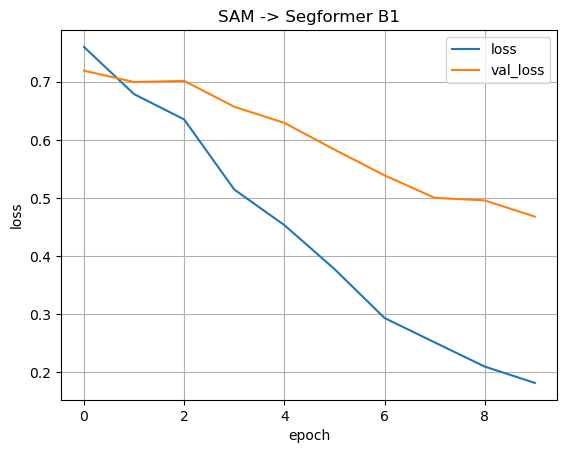

In [8]:
plt.figure()
plt.plot(lc['loss'],label='loss')
plt.plot(lc['val_loss'],label='val_loss')
plt.title('SAM -> Segformer B1')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

印出來看看

印出來看看👀


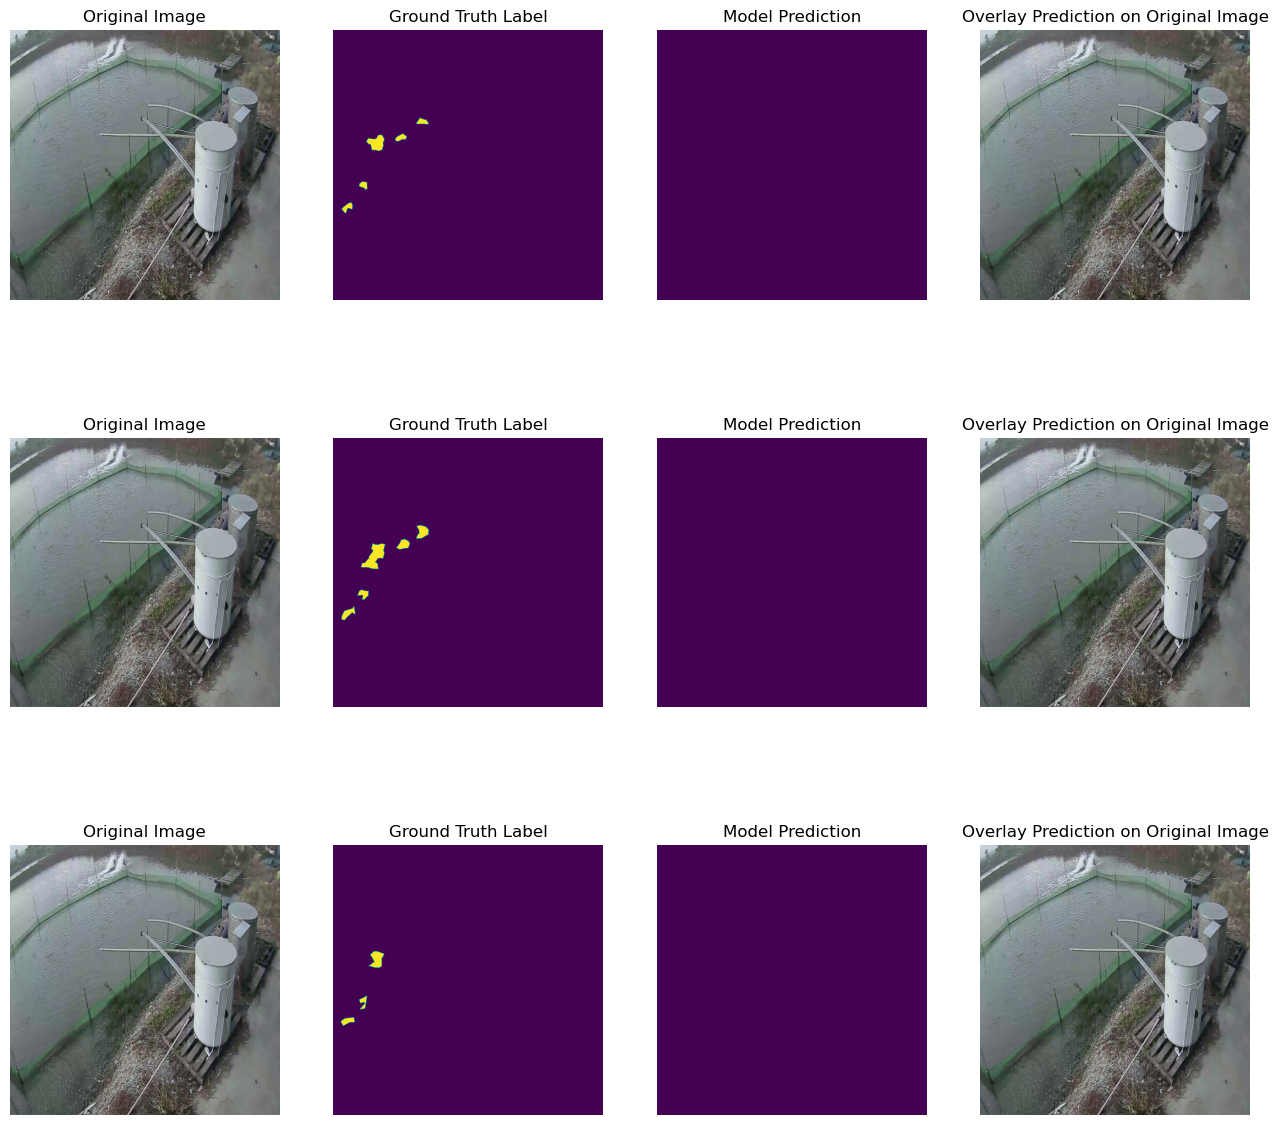

outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
tensor([[[[ 0.2332,  0.2332,  0.2348,  ...,  0.2064,  0.2073,  0.2073],
          [ 0.2332,  0.2332,  0.2348,  ...,  0.2064,  0.2073,  0.2073],
          [ 0.2325,  0.2325,  0.2344,  ...,  0.2063,  0.2075,  0.2075],
          ...,
          [ 0.3018,  0.3018,  0.3119,  ...,  0.3107,  0.3116,  0.3116],
          [ 0.2997,  0.2997,  0.3102,  ...,  0.3131,  0.3137,  0.3137],
          [ 0.2997,  0.2997,  0.3102,  ...,  0.3131,  0.3137,  0.3137]],

         [[-0.3205, -0.3205, -0.3182,  ..., -0.3461, -0.3472, -0.3472],
          [-0.3205, -0.3205, -0.3182,  ..., -0.3461, -0.3472, -0.3472],
          [-0.3171, -0.3171, -0.3152,  ..., -0.3472, -0.3488, -0.3488],
          ...,
          [-0.2703, -0.2703, -0.2769,  ..., -0.3342, -0.3354, -0.3354],
          [-0.2678, -0.2678, -0.2747,  ..., -0.3347, -0.3356, -0.3356],
          [-0.2678, -0.2678, -0.2747,  ..., -0.3347, -0.3356, -0.3356]]]],
       device='cuda:0', grad_fn=<UpsampleBiline

In [9]:
print("印出來看看👀")
showSegmentationResult(segformer_model, dataset_val)

In [10]:
"""
############################################################### Teacher Model : SAM
# define SAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Retrieve the image embeddings
# processor
inputs = processor(image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

# 待加功能$$$$$
# setup prompts : target points, bounding box
input_boxes = [[[250, 300, 700, 550]]]
input_points = [[[500, 400], [600, 400]]]

# 送到processor計算遮罩
inputs = processor(image, input_boxes=[input_boxes], input_points=[input_points], return_tensors="pt").to(device)
# inputs = processor(raw_image, input_points=[input_points], return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks, teacher_output = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

###############################################################
"""

'\n############################################################### Teacher Model : SAM\n# define SAM\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)\nprocessor = SamProcessor.from_pretrained("facebook/sam-vit-huge")\n\n# Retrieve the image embeddings\n# processor\ninputs = processor(image, return_tensors="pt").to(device)\nimage_embeddings = model.get_image_embeddings(inputs["pixel_values"])\n\n# 待加功能$$$$$\n# setup prompts : target points, bounding box\ninput_boxes = [[[250, 300, 700, 550]]]\ninput_points = [[[500, 400], [600, 400]]]\n\n# 送到processor計算遮罩\ninputs = processor(image, input_boxes=[input_boxes], input_points=[input_points], return_tensors="pt").to(device)\n# inputs = processor(raw_image, input_points=[input_points], return_tensors="pt").to(device)\n\ninputs.pop("pixel_values", None)\ninputs.update({"image_embeddings": image_embeddings})\n\nwith torch.no_grad():\n    outputs = model(*